# A Neural Algorithm of Artistic Style
This is a jupyter notebook implementing [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576). This implementation takes elements from [Improving the Neural Algorithm of Artistic Style](http://arxiv.org/abs/1605.04603) and is an extensions of [@titu1994](https://github.com/titu1994)'s [implementation](https://github.com/titu1994/Neural-Style-Transfer/blob/master/INetwork.py)

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
from scipy.misc import imread, imresize, imsave, fromimage, toimage
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import time
import warnings
from __future__ import print_function

In [77]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model

In [78]:
# Verify that the backend matches the image dimension ordering.
if K.backend() == 'tensorflow' and K.image_dim_ordering() == "th":
    # TODO package this into a tools file.
    warnings.warn('You are using the TensorFlow backend, yet you '
                  'are using the Theano '
                  'image dimension ordering convention '
                  '(`image_dim_ordering="th"`). '
                  'For best performance, set '
                  '`image_dim_ordering="tf"` in '
                  'your Keras config '
                  'at ~/.keras/keras.json.')
    convert_all_kernels_in_model(model)

## Setting model parameters
### Load Images

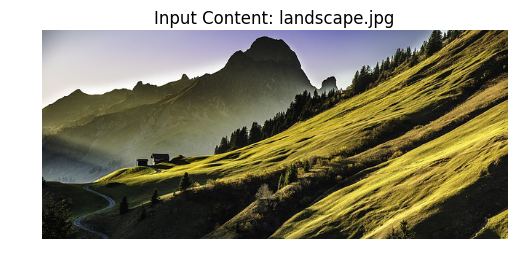

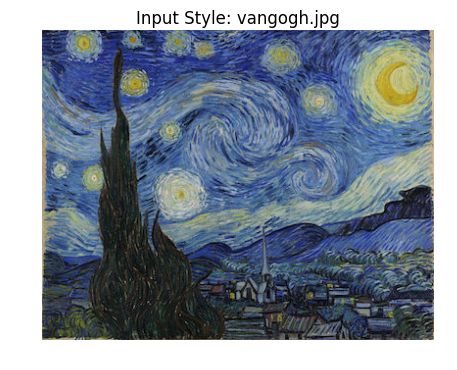

In [111]:
base_image_path = 'landscape.jpg'# Path to the image to transform.
style_image_paths = ['vangogh.jpg']# Path to the style reference image[s].
result_prefix = 'style'# Prefix for the saved results.
def showImages(list_of_files, title=""):
    fig = plt.figure()
    if title:
        plt.title(title)
        plt.axis('off')
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        if number_of_files == 1:
            plt.title(title +": " +list_of_files[i])
        else:
            plt.title(list_of_files[i])
        plt.imshow(image,cmap='Greys_r')
        plt.axis('off')
showImages([base_image_path], 'Input Content')
showImages(style_image_paths, 'Input Style')

### Neural Network parameters

In [ ]:
# Mask setup
mask_paths = [] # Masks for style images
color_mask = None # Leave as None, or specify a mask

# Output Image settings
img_width = img_height = 400 # Change the side length. Grammian just restricts to square images.
preserve_color = False # Make true if you want to preserv the color of the content image. 

# Content weighting
content_weight = 0.025 # How much you want the content to affect the total cost
style_weights = [1] # weights of different styles
style_scale = 1 # Different style scaling
total_variation_weight = 8.5e-5 # Total Variation in the Weights

# Training variables
num_iter = 10 # Number of iterations to go through.
vgg_model = 'vgg16' # The ImageNet model you want to train and use. choices are 'vgg16' and 'vgg19'
content_loss_type = 0 # Can be 0, 1, or 2. TODO README.
rescale_image = False # Rescale image after execution to original dimentions
rescale_method = 'bilinear' # Image rescaling algorithm. nearest’, ‘lanczos’, ‘bilinear’, ‘bicubic’ or ‘cubic’.
maintain_aspect_ratio = True
content_layer = "conv5_2" # Specify what layer contains the content of the image. Check feature_layers for options
init_image="content" # Initial image used to generate the final image. Options are 'content', 'noise', or 'gray'
pooltype = "max" # Pooling type. Can be "ave" for average pooling or "max" for max pooling 

improvement_threshold = 0.0 # The threshold that dicates when to stop iterating. Keep at 0 to finish all iterations.

#### Argument checking
Run this cell to make sure your arguments are legal and perform necessary preprocessing. IF you don't run this cell, your program will fail or act unexpectedly.

You should only be worried if errors are thrown.

In [80]:
style_masks_present = len(mask_paths) > 0
if style_masks_present:
    assert len(style_image_paths) == len(mask_paths), "Wrong number of style masks provided.\n" \
                                                               "Number of style images = %d, \n" \
                                                               "Number of style mask paths = %d." % \
                                                               (len(style_image_paths), len(style_masks_present))
if len(style_image_paths) != len(style_weights):
    print("Mismatch in number of style images provided and number of style weights provided. \n"
          "Found %d style images and %d style weights. \n"
          "Equally distributing weights to all styles." % (len(style_image_paths), len(style_weights)))

    weight_sum = sum(style_weights) * style_scale
    count = len(style_image_paths)
    style_weights = [weight_sum / count] * count
else:
    style_weights = [w * style_scale for w in style_weights]

assert vgg_model in ('vgg16', 'vgg19'), "You must choose either 'vgg16' or 'vgg19' as your model type."
assert content_loss_type in [0, 1, 2], "Content Loss Type must be one of 0, 1 or 2"
assert init_image in ["content", "noise", "gray"], "init_image must be one of ['content', 'noise', 'gray']"

assert pooltype in ["ave", "max"], 'Pooling argument is wrong. Needs to be either "ave" or "max".'

In [81]:
# TODO deal with this.
img_WIDTH = img_HEIGHT = 0
aspect_ratio = 0

## Image Processing Utils

In [82]:
# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path, load_dims=False, read_mode="color"):
    global img_WIDTH, img_HEIGHT, aspect_ratio

    mode = "RGB" if read_mode == "color" else "L"
    img = imread(image_path, mode=mode)  # Prevents crashes due to PNG images (ARGB)

    if mode == "L":
        # Expand the 1 channel grayscale to 3 channel grayscale image
        temp = np.zeros(img.shape + (3,), dtype=np.uint8)
        temp[:, :, 0] = img
        temp[:, :, 1] = img.copy()
        temp[:, :, 2] = img.copy()

        img = temp

    if load_dims:
        img_WIDTH = img.shape[0]
        img_HEIGHT = img.shape[1]
        aspect_ratio = img_HEIGHT / img_WIDTH

    img = imresize(img, (img_width, img_height)).astype('float32')

    # RGB -> BGR
    img = img[:, :, ::-1]

    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68

    if K.image_dim_ordering() == "th":
        img = img.transpose((2, 0, 1)).astype('float32')

    img = np.expand_dims(img, axis=0)
    return img


# util function to convert a tensor into a valid image
def deprocess_image(x):
    if K.image_dim_ordering() == "th":
        x = x.reshape((3, img_width, img_height))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_width, img_height, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR -> RGB
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [83]:
# util function to preserve image color
def original_color_transform(content, generated, mask=None):
    generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')  # Convert to YCbCr color space

    if mask is None:
        generated[:, :, 1:] = content[:, :, 1:]  # Generated CbCr = Content CbCr
    else:
        width, height, channels = generated.shape

        for i in range(width):
            for j in range(height):
                if mask[i, j] == 1:
                    generated[i, j, 1:] = content[i, j, 1:]

    generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')  # Convert to RGB color space
    return generated

In [84]:
def load_mask(mask_path, shape, return_mask_img=False):
    if K.image_dim_ordering() == "th":
        _, channels, width, height = shape
    else:
        _, width, height, channels = shape

    mask = imread(mask_path, mode="L") # Grayscale mask load
    mask = imresize(mask, (width, height)).astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    max = np.amax(mask)
    mask /= max

    if return_mask_img: return mask

    mask_shape = shape[1:]

    mask_tensor = np.empty(mask_shape)

    for i in range(channels):
        if K.image_dim_ordering() == "th":
            mask_tensor[i, :, :] = mask
        else:
            mask_tensor[:, :, i] = mask

    return mask_tensor

In [85]:
# Decide pooling function
def pooling_func():
    if pooltype == "ave":
        return AveragePooling2D((2, 2), strides=(2, 2))
    else:
        return MaxPooling2D((2, 2), strides=(2, 2))


read_mode = "gray" if init_image == "gray" else "color"
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path, True, read_mode=read_mode))

style_reference_images = []
for style_path in style_image_paths:
    style_reference_images.append(K.variable(preprocess_image(style_path)))

# this will contain our generated image
if K.image_dim_ordering() == 'th':
    combination_image = K.placeholder((1, 3, img_width, img_height))
else:
    combination_image = K.placeholder((1, img_width, img_height, 3))

image_tensors = [base_image]
for style_image_tensor in style_reference_images:
    image_tensors.append(style_image_tensor)
image_tensors.append(combination_image)

nb_tensors = len(image_tensors)
nb_style_images = nb_tensors - 2 # Content and Output image not considered

# combine the various images into a single Keras tensor
input_tensor = K.concatenate(image_tensors, axis=0)

if K.image_dim_ordering() == "th":
    shape = (nb_tensors, 3, img_width, img_height)
else:
    shape = (nb_tensors, img_width, img_height, 3)

In [86]:
# build the VGG16 network with our 3 images as input
first_layer = Convolution2D(64, 3, 3, activation='relu', name='conv1_1', border_mode='same')
first_layer.set_input(input_tensor, shape)

model = Sequential()
model.add(first_layer)
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2', border_mode='same'))
model.add(pooling_func())

model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1', border_mode='same'))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2', border_mode='same'))
model.add(pooling_func())

model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1', border_mode='same'))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2', border_mode='same'))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3', border_mode='same'))
if vgg_model == "vgg19":
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_4', border_mode='same'))
model.add(pooling_func())

model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1', border_mode='same'))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2', border_mode='same'))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3', border_mode='same'))
if vgg_model == "vgg19":
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_4', border_mode='same'))
model.add(pooling_func())

model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1', border_mode='same'))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2', border_mode='same'))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3', border_mode='same'))
if vgg_model == "vgg19":
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_4', border_mode='same'))
model.add(pooling_func())

In [87]:
weights_origins = {
    ('vgg19', 'th') : 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_th_dim_ordering_th_kernels_notop.h5',
    ('vgg19', 'tf') : 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
    ('vgg16', 'th') : 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5',
    ('vgg16', 'tf') : 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
}

In [88]:
# load VGG weights
weights_tuple = (vgg_model, K.image_dim_ordering())

filename = '{0}_weights_{1}_dim_ordering_{1}_kernels_notop.h5'.format(*weights_tuple)
weights = get_file(filename, weights_origins[weights_tuple], cache_subdir='models')
model.load_weights(weights)
print('Model loaded.')

Model loaded.


In [89]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
shape_dict = dict([(layer.name, layer.output_shape) for layer in model.layers])

### Compute the neural style loss
First we need to define 4 util functions

In [90]:
# Improvement 1
# the gram matrix of an image tensor (feature-wise outer product) using shifted activations
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == "th":
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features - 1, K.transpose(features - 1))
    return gram


# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination, mask_path=None, nb_channels=None):
    assert K.ndim(style) == 3, "Style matrix must have 3 dimensions. Found {}.".format(K.ndim(style))
    assert K.ndim(combination) == 3, "Combination matrix must have 3 dimensions. Found {}.".format(K.ndim(combination))

    if mask_path is not None:
        style_mask = load_mask(mask_path, nb_channels)

        style = style * style_mask
        combination = combination * style_mask

        del style_mask

    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_width * img_height
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    channel_dim = 0 if K.image_dim_ordering() == "th" else K.ndim(K.shape(base)) - 1

    channels = K.shape(base)[channel_dim]
    size = img_width * img_height

    if content_loss_type == 1:
        multiplier = 1 / (2. * channels ** 0.5 * size ** 0.5)
    elif content_loss_type == 2:
        multiplier = 1 / (channels * size)
    else:
        multiplier = 1.

    return multiplier * K.sum(K.square(combination - base))


# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_dim_ordering() == 'th':
        a = K.square(x[:, :, :img_width - 1, :img_height - 1] - x[:, :, 1:, :img_height - 1])
        b = K.square(x[:, :, :img_width - 1, :img_height - 1] - x[:, :, :img_width - 1, 1:])
    else:
        a = K.square(x[:, :img_width - 1, :img_height - 1, :] - x[:, 1:, :img_height - 1, :])
        b = K.square(x[:, :img_width - 1, :img_height - 1, :] - x[:, :img_width - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [91]:
if vgg_model == "vgg19":
    feature_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4',
                      'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4']
else:
    feature_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3',
                      'conv4_1', 'conv4_2', 'conv4_3', 'conv5_1', 'conv5_2', 'conv5_3']

# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[nb_tensors - 1, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)
# Improvement 2
# Use all layers for style feature extraction and reconstruction
nb_layers = len(feature_layers) - 1

style_masks = []
if style_masks_present:
    style_masks = mask_paths # If mask present, pass dictionary of masks to style loss
else:
    style_masks = [None for _ in range(nb_style_images)] # If masks not present, pass None to the style loss

channel_index = 1 if K.image_dim_ordering() == "th" else -1

In [92]:
# Improvement 3 : Chained Inference without blurring
for i in range(nb_layers):
    layer_features = outputs_dict[feature_layers[i]]
    shape = shape_dict[feature_layers[i]]
    combination_features = layer_features[nb_tensors - 1, :, :, :]
    style_reference_features = layer_features[1:nb_tensors - 1, :, :, :]
    sl1 = []
    for j in range(nb_style_images):
        ref_feats = layer_features[j+1, :, :, :]
        cur_mask = style_masks[j]
        sl1.append(style_loss(ref_feats, combination_features, cur_mask, shape))

    layer_features = outputs_dict[feature_layers[i + 1]]
    shape = shape_dict[feature_layers[i + 1]]
    combination_features = layer_features[nb_tensors - 1, :, :, :]
    style_reference_features = layer_features[1:nb_tensors - 1, :, :, :]
    sl2 = []
    for j in range(nb_style_images):
        ref_feats = layer_features[j+1, :, :, :]
        sl2.append(style_loss(ref_feats, combination_features, style_masks[j], shape))

    for j in range(nb_style_images):
        sl = sl1[j] - sl2[j]

        # Improvement 4
        # Geometric weighted scaling of style loss
        loss += (style_weights[j] / (2 ** (nb_layers - (i + 1)))) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)


In [93]:

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((1, 3, img_width, img_height))
    else:
        x = x.reshape((1, img_width, img_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss


if "content" in init_image or "gray" in init_image:
    x = preprocess_image(base_image_path, True, read_mode=read_mode)
else:
    x = np.random.uniform(0, 255, (1, img_width, img_height, 3)) - 128.

    if K.image_dim_ordering() == "th":
        x = x.transpose((0, 3, 1, 2))

# We require original image if we are to preserve color in YCbCr mode
if preserve_color:
    content = imread(base_image_path, mode="YCbCr")
    content = imresize(content, (img_width, img_height))

    if color_mask is not None:
        if K.image_dim_ordering() == "th":
            color_mask_shape = (None, None, img_width, img_height)
        else:
            color_mask_shape = (None, img_width, img_height, None)

        color_mask = load_mask(color_mask, color_mask_shape, return_mask_img=True)
    else:
        color_mask = None
else:
    color_mask = None

prev_min_val = -1

In [94]:
for i in range(num_iter):
    print("Start of iteration", (i + 1))
    start_time = time.time()

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)

    if prev_min_val == -1:
        prev_min_val = min_val

    improvement = (prev_min_val - min_val) / prev_min_val * 100

    print("Current loss value:", min_val, " Improvement : %0.3f" % improvement, "%")
    prev_min_val = min_val
    # save current generated image
    img = deprocess_image(x.copy())

    if preserve_color and content is not None:
        img = original_color_transform(content, img, mask=color_mask)

    if maintain_aspect_ratio & (not rescale_image):
        img_ht = int(img_width * aspect_ratio)
        print("Rescaling Image to (%d, %d)" % (img_width, img_ht))
        img = imresize(img, (img_width, img_ht), interp=rescale_method)

    if rescale_image:
        print("Rescaling Image to (%d, %d)" % (img_WIDTH, img_HEIGHT))
        img = imresize(img, (img_WIDTH, img_HEIGHT), interp=rescale_method)

    fname = result_prefix + "_at_iteration_%d.png" % (i + 1)
    plt.imshow(img)
    plt.title(fname)
    plt.show()
    imsave(fname, img)
    end_time = time.time()
    print("Image saved as", fname)
    print("Iteration %d completed in %ds" % (i + 1, end_time - start_time))

    if improvement_threshold is not 0.0:
        if improvement < improvement_threshold and improvement is not 0.0:
            print("Improvement (%f) is less than improvement threshold (%f). Early stopping script." %
                  (improvement, improvement_threshold))
            exit()

Start of iteration 1


KeyboardInterrupt: 